# PHXS 491_001: Observational Astronomy - Homework 6

### Due Oct 26, 2021
Remember to save your completed notebook as a PDF and upload to Brightspace under Assignments.

Name: William Jardee

## Please use the "primt()" function (notice the "m") to print out your answers in magenta.  This makes grading easier.  You might need to "print to PDF" to get the colors to show up.

In [1]:
def primt(*args):
    '''
    For any amount of arguments "*args", prints in magenta.
    '''
    magenta = "\x1B[38;5;201m"   # the color in ANSI code
    string = ""
    for el in args:  # for each argument
        string += " "+(str(el))  # add the argument to the string to be printed
    magenta += string[1:]
    print(magenta)   #print!

# Dark and Flat calibration, error image

In [2]:
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy
from astropy import stats
import numpy as np
import os
from glob import glob
import matplotlib
# matplotlib.use('nbagg')
# %matplotlib notebook

In [3]:
# A little script to get information on all the fits files
def ccdlist(input=None):
    if input is None: input='*.fits'
    files = glob(input)
    nfiles = len(files)
    dt = np.dtype([('file',str,100),('naxis1',int),('naxis2',int),
                      ('imagetyp',str,100),('exptime',float),('filter',str,100)])
    cat = np.zeros(nfiles,dtype=dt)
    for i,f in enumerate(files):
        base = os.path.basename(f)
        base = base.split('.')[0]
        h = fits.getheader(f)
        cat['file'][i] = f
        cat['naxis1'][i] = h.get('naxis1')
        cat['naxis2'][i] = h.get('naxis2')
        cat['imagetyp'][i] = h.get('imagetyp')
        cat['exptime'][i] = h.get('exptime')
        cat['filter'][i] = h.get('filter')
        print(base+'  '+str(cat['naxis1'][i])+'  '+str(cat['naxis2'][i])+'  '+cat['imagetyp'][i]+'  '+str(cat['exptime'][i])+'  '+cat['filter'][i])
    return cat

### Unzip the ``calibration_data.zip`` file and load the information using the ``ccdlist`` function.

In [4]:
out=ccdlist('data/calibration_data/*.fit')

Bias-0001  3468  2728  Bias Frame  0.001000000047497  None
Bias-0002  3468  2728  Bias Frame  0.001000000047497  None
Bias-0003  3468  2728  Bias Frame  0.001000000047497  None
Bias-0004  3468  2728  Bias Frame  0.001000000047497  None
Bias-0005  3468  2728  Bias Frame  0.001000000047497  None
Bias-0006  3468  2728  Bias Frame  0.001000000047497  None
Bias-0007  3468  2728  Bias Frame  0.001000000047497  None
Bias-0008  3468  2728  Bias Frame  0.001000000047497  None
Bias-0009  3468  2728  Bias Frame  0.001000000047497  None
Bias-0010  3468  2728  Bias Frame  0.001000000047497  None
DoubleCluster-0003B  3468  2728  Light Frame  120.0  Blue
DoubleCluster-0003R  3468  2728  Light Frame  120.0  Red
DoubleCluster-0023B  3468  2728  Light Frame  30.0  Green
master_dark  3388  2712  Dark Frame  60.0  None
master_flat  3388  2712  Light Frame  30.0  None


## 1. Dark

Write a function called ``overscantrimzerodark()`` that overscan corrects, trims, subtracts the ``master bias``, and subtracts the ``master dark`` scaled to an image's exposure time.

In [5]:
  def overscantrim(im1):
    over_right = im1[:,3429:-3]    # right
    over_left = im1[:,0:40]        # left
    over_bot = im1[0:14,:-3]       # bottom
    im1_data = im1[13:-3,41:3429]  # data
    
    over = np.append(over_right.flatten(), over_left.flatten())
    over = np.append(over.flatten(), over_bot.flatten())
    over_sig_mean = astropy.stats.sigma_clipped_stats(over)[0]    #use a sigma clipped mean to be robust against outliers
    return im1_data - over_sig_mean

def overscantrimzerodark(im1, head, path=False):
    if path is False: path = 'data/calibration_data/'
        
    # construct our data
    over_right = im1[:,3429:-3]    # right
    over_left = im1[:,0:40]        # left
    over_bot = im1[0:13,:-3]       # bottom
    im1_data = im1[13:-3,41:3429]  # data
    
    # subtract overscan
    over = np.append(over_right.flatten(), over_left.flatten())
    over = np.append(over.flatten(), over_bot.flatten())
    over_sig_mean = astropy.stats.sigma_clipped_stats(over)[0]    #use a sigma clipped mean to be robust against outliers
    im1_data = im1_data - over_sig_mean
    
    # crafting bias image
    biases = np.where("Bias Frame" == out['imagetyp'])
    bias_list = out[biases]['file']

    trimmed_bias = np.zeros([len(bias_list), head['NAXIS2']-16, head['NAXIS1']-80])
    for i in range(len(bias_list)):
        bias_im = fits.getdata(bias_list[i].replace("\\", "/"),0,header=True)[0]
        trimmed_bias[i] = overscantrim(bias_im)

    im1_data = im1_data - np.mean(trimmed_bias, axis=0) # subtract bias
    
    # get and subtract master dark
    master_dark, dark_head = fits.getdata(path + 'master_dark.fit',0,header=True)
    im1_data = im1_data - master_dark*head['EXPOSURE']/dark_head['EXPOSURE']
    
    return im1_data

## 2. Flat

Write a function called ``overscantrimzerodarkflat()`` that overscan corrects, trims, subtracts the ``master bias``, subtracts the ``master dark`` scaled to an image's exposure time, and divides by the ``master flat``.

In [6]:
def overscantrimzerodarkflat(im1, head, path=False):
    if path is False: path= 'data/calibration_data/'
        
    # construct our data
    over_right = im1[:,3429:-3]    # right
    over_left = im1[:,0:40]        # left
    over_bot = im1[0:13,:-3]       # bottom
    im1_data = im1[13:-3,41:3429]  # data
    
    # subtract overscan
    over = np.append(over_right.flatten(), over_left.flatten())
    over = np.append(over.flatten(), over_bot.flatten())
    over_sig_mean = astropy.stats.sigma_clipped_stats(over)[0]    #use a sigma clipped mean to be robust against outliers
    im1_data = im1_data - over_sig_mean
    
    # crafting bias image
    biases = np.where("Bias Frame" == out['imagetyp'])
    bias_list = out[biases]['file']

    trimmed_bias = np.zeros([len(bias_list), head['NAXIS2']-16, head['NAXIS1']-80])
    for i in range(len(bias_list)):
        bias_im = fits.getdata(bias_list[i].replace("\\", "/"),0,header=True)[0]
        trimmed_bias[i] = overscantrim(bias_im)

    im1_data = im1_data - np.mean(trimmed_bias, axis=0) # subtract bias
    
    # get and subtract master dark
    master_dark, dark_head = fits.getdata(path + 'master_dark.fit',0,header=True)
    im1_data = im1_data - master_dark*head['EXPOSURE']/dark_head['EXPOSURE']
    
    # get and divide by master flat
    master_flat = fits.getdata('data/calibration_data/master_flat.fit',0,header=False)
    im1_data = im1_data/master_flat

    return im1_data

## 3. Error/noise Array

Create an array of the errors or noise in each pixels.  This will have two components: 1) the Poisson noise from the flux in the image (from objects, sky and dark current), and 2) the read noise.  Add these two in quadrature.  Make sure to take the gain into account when computing the Poisson noise.  Give it in ADUs like the original image.  Update your ``overscantrimzerodarkflat()`` function to calculate and output the error array.

In [7]:
def overscantrimzerodarkflat(im1, head, path=False):
    if path is False: path= 'data/calibration_data/'
        
    # construct our data
    over_right = im1[:,3429:-3]    # right
    over_left = im1[:,0:40]        # left
    over_bot = im1[0:13,:-3]       # bottom
    im1_data = im1[13:-3,41:3429]  # data
    
    # subtract overscan
    over = np.append(over_right.flatten(), over_left.flatten())
    over = np.append(over.flatten(), over_bot.flatten())
    over_sig_mean = astropy.stats.sigma_clipped_stats(over)[0]    #use a sigma clipped mean to be robust against outliers
    im1_data = im1_data - over_sig_mean
    
    # crafting bias image
    biases = np.where("Bias Frame" == out['imagetyp'])
    bias_list = out[biases]['file']

    trimmed_bias = np.zeros([len(bias_list), head['NAXIS2']-16, head['NAXIS1']-80])
    for i in range(len(bias_list)):
        bias_im = fits.getdata(bias_list[i].replace("\\", "/"),0,header=True)[0]
        trimmed_bias[i] = overscantrim(bias_im)

    im1_data = im1_data - np.mean(trimmed_bias, axis=0) # subtract bias
    
    # get and subtract master dark
    master_dark, dark_head = fits.getdata(path + 'master_dark.fit',0,header=True)
    im1_data = im1_data - master_dark*head['EXPOSURE']/dark_head['EXPOSURE']
    
    # get and divide by master flat
    master_flat = fits.getdata('data/calibration_data/master_flat.fit',0,header=False)
    im1_data = im1_data/master_flat

    # calculating error matrix
    err = (im1_data*head['EGAIN']+master_dark*dark_head['EGAIN']+dark_head['RDNOISE']**2)**(1/2)/dark_head['EGAIN']
    
    return im1_data, err

## 4. Science Frames

Run your program on the two ``DoubleCluster`` images with the provided master dark and flat images.

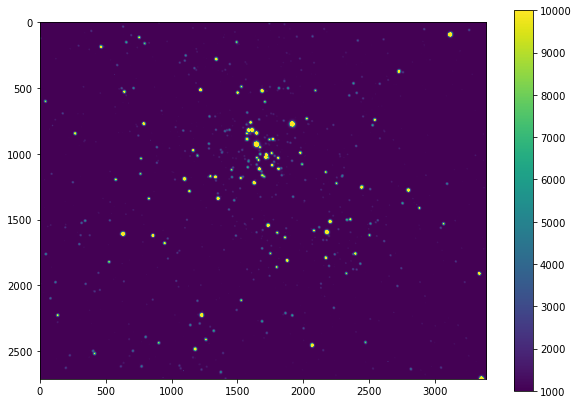

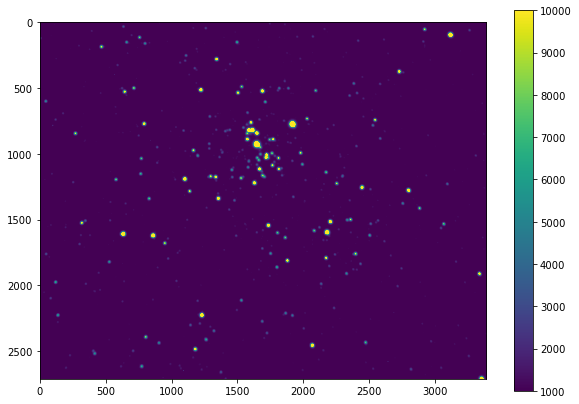

In [8]:
im, head = fits.getdata('data/calibration_data/DoubleCluster-0003B.fit',0,header=True)

im_pros1, im_err1 = overscantrimzerodarkflat(im, head)

plt.figure(figsize=(10,7))
plt.imshow(im_pros1, vmin=1000, vmax=10000)
plt.colorbar()
plt.show()


im, head = fits.getdata('data/calibration_data/DoubleCluster-0003R.fit',0,header=True)

im_pros2, im_err2 = overscantrimzerodarkflat(im, head)

plt.figure(figsize=(10,7))
plt.imshow(im_pros2, vmin=1000, vmax=10000)
plt.colorbar()
plt.show()

## 5. History and Provenance

It is useful to know what operations have been performed on an image.  Therefore, it is common to put HISTORY/COMMENT cards in the header whenever an operation has been taken or other keywords.

```
OVSNMEAN=             1436.145                                                  
TRIM    = 'Oct  8 21:17 Trim is [25:1048,1:4096]'                               
FIXPIX  = 'Oct  8 21:17 Fix mscdb$noao/Mosaic2/CAL0102/bpm1_0102 + sat + bleed' 
OVERSCAN= 'Oct  8 21:17 Overscan is [1063:1112,1:4096], mean 1436.145'          
ZEROCOR = 'Oct  8 21:17 Zero is Zero[im1]'                                      
FLATCOR = 'Oct  8 21:17 Flat is DFlatI.fits[im1], scale 10494.14'               
CCDPROC = 'Oct 18 11:33 CCD processing done'    
```

Go back to your ``overscantrimzerodarkflat()`` function and add lines to put HISTORY statements in the header after a processing step was performed.  For HISTORY use the .add_history() method of the header object.  For a new keyword just use ```head["NEWKEY"]=newvalue```.  You might need to modify your function to take the header as an input.

In [9]:
from datetime import datetime

def overscantrimzerodarkflat(im1, head, path=False):
    if path is False: path= 'data/calibration_data/'
        
    # construct our data
    over_right = im1[:,3429:-3]    # right
    over_left = im1[:,0:40]        # left
    over_bot = im1[0:13,:-3]       # bottom
    im1_data = im1[13:-3,41:3429]  # data
    head.add_history("image processed (trim/overscan): " + str(datetime.now())[:-7] + 
                     "; trim is: [13:-3,41:3429], overscan is: everything else") # points to original head object, so updated in pace
    
    # subtract overscan
    over = np.append(over_right.flatten(), over_left.flatten())
    over = np.append(over.flatten(), over_bot.flatten())
    over_sig_mean = astropy.stats.sigma_clipped_stats(over)[0]    #use a sigma clipped mean to be robust against outliers
    im1_data = im1_data - over_sig_mean
    
    # crafting bias image
    biases = np.where("Bias Frame" == out['imagetyp'])
    bias_list = out[biases]['file']

    trimmed_bias = np.zeros([len(bias_list), head['NAXIS2']-16, head['NAXIS1']-80])
    for i in range(len(bias_list)):
        bias_im = fits.getdata(bias_list[i].replace("\\", "/"),0,header=True)[0]
        trimmed_bias[i] = overscantrim(bias_im)

    im1_data = im1_data - np.mean(trimmed_bias, axis=0) # subtract bias
    head.add_history("image processed (bias): " + str(datetime.now())[:-7] + f"; {len(bias_list)} bias frames") # points to original head object, so updated in pace
    
    # get and subtract master dark
    master_dark, dark_head = fits.getdata(path + 'master_dark.fit',0,header=True)
    im1_data = im1_data - master_dark*head['EXPOSURE']/dark_head['EXPOSURE']
    head.add_history("image processed (dark): " + str(datetime.now())[:-7]) # points to original head object, so updated in pace
    
    # get and divide by master flat
    master_flat = fits.getdata('data/calibration_data/master_flat.fit',0,header=False)
    im1_data = im1_data/master_flat
    head.add_history("image processed (flat): " + str(datetime.now())[:-7]) # points to original head object, so updated in pace
    
    # calculating error matrix
    err = (im1_data*head['EGAIN']+master_dark*dark_head['EGAIN']+dark_head['RDNOISE']**2)**(1/2)/dark_head['EGAIN']
    
    
    return im1_data, head, err

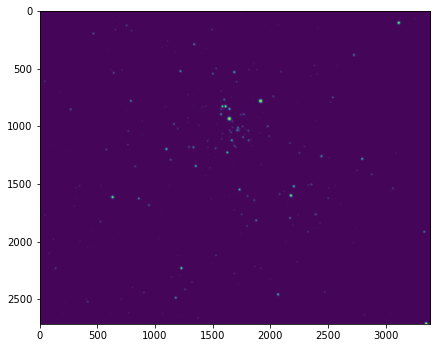

SIMPLE  =                    T /                                                
BITPIX  =                   16 /  8 unsigned int, 16 & 32 int, -32 & -64 real   
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 3468 /fastest changing axis                           
NAXIS2  =                 2728 /next to fastest changing axis                   
EXTEND  =                    T /   Extensions may be present                    
BSCALE  =                    1 /  physical = BZERO + BSCALE*array_value         
BZERO   =                32768 /  physical = BZERO + BSCALE*array_value         
DATE-OBS= '2020-02-22T04:08:19.00' /YYYY-MM-DDThh:mm:ss observation start, UT   
EXPTIME =   120.00000000000000 /Exposure time in seconds                        
EXPOSURE=   120.00000000000000 /Exposure time in seconds                        
SET-TEMP=  -20.000000000000000 /CCD temperature setpoint in C                   
CCD-TEMP=  -20.2000007629394

In [10]:
im, head = fits.getdata('data/calibration_data/DoubleCluster-0003B.fit',0,header=True)

im_pros, head, im_err = overscantrimzerodarkflat(im, head)

plt.figure(figsize=(7,7))
plt.imshow(im_pros)
plt.show()
head

In [8]:
import bozepy

In [10]:
? bozepy